In [269]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer

In [177]:
import numpy as np
from scipy import sparse
from scipy import special


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef=0):
        """
        Задание параметров оракула.
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.alpha = l2_coef

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        M =  - X.dot(w) * y
        helper = np.zeros(M.shape)
        loss = np.sum(np.logaddexp(helper, M)) / M.shape[0]
        loss += np.sum(w ** 2) * self.alpha / 2
        return loss
    
    def mul_help(self, X, y):
        if sparse.issparse(X):
            return X.multiply(y[:, np.newaxis])
        else:
            return (X * y[:, np.newaxis])

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        M =  - X.dot(w) * y
        gradient = self.mul_help(self.mul_help(X, y), special.expit(M))
        gradient = self.alpha * w - gradient.sum(axis=0) / M.shape[0]
        return np.ravel(gradient)


In [178]:
import time
import numpy as np
from scipy import sparse
from scipy import special
import oracles


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(self, loss_function='binary_logistic', step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta - float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход
        
        max_iter - максимальное число итераций
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        if loss_function == 'binary_logistic':
            self.loss_function = loss_function
        else:
            raise NotImplementedError('GDClassifier is not implemented.')
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        self.threshold = 0.6
        self.history = {}

    def fit(self, X, y, w_0=None, trace=False, accuracy=False, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        if not w_0 is None:
            self.weights = w_0.copy()
        else:
            self.weights = np.random.uniform(-1, 1, X.shape[1])
        my_oracle = BinaryLogistic(**self.kwargs)
        self.history['time'] = [0]
        self.history['func'] = [0]
        if accuracy:
            self.history['accuracy'] = [0]
        start_time = time.time()
        for n in range(0, self.max_iter + 1):
            grad = my_oracle.grad(X, y, self.weights)
            loss = my_oracle.func(X, y, self.weights)
            self.weights -= (self.step_alpha / (n + 1) ** self.step_beta) * grad
            if accuracy:
                y_pred = self.predict(X_test)
                accur = accuracy_score(y_test, y_pred)
            if n > 0:
                self.history['func'].append(loss)
                self.history['time'].append(time.time() - start_time)
                if accuracy:
                    self.history['accuracy'].append(accur)
                if np.abs(loss - self.history['func'][n - 1]) < self.tolerance:
                    break
            else:
                self.history['func'] = [loss]
                self.history['time'] = [time.time() - start_time]
                if accuracy:
                    self.history['accuracy'] = [accur]
        if trace:
            return self.history
        if accuracy:
            return self.history['accuracy']

    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        y_pred = (-1) ** ((X.dot(self.weights) > 0) + 1)
        return y_pred

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерный numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        p_pred = special.expit(X.dot(self.weights))
        return np.vstack((1 - p_pred, p_pred))

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        my_oracle = oracles.BinaryLogistic(self.kwargs)
        return my_oracle.func(X, y, self.weights)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        my_oracle = oracles.BinaryLogistic(self.kwargs)
        return my_oracle.grad(X, y, self.weights)

    def get_weights(self):
        """
        Получение значения весов функционала
        """    
        return self.weights


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        
        max_iter - максимальное число итераций (эпох)
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        if loss_function == 'binary_logistic':
            self.loss_function = loss_function
        else:
            raise NotImplementedError('SGDClassifier is not implemented.')
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.kwargs = kwargs
        self.history = {}

    def fit(self, X, y, w_0=None, trace=False, log_freq=1, accuracy=False, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет 
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)
        if not w_0 is None:
            self.weights = w_0.copy()
        else:
            self.weights = np.random.uniform(-1, 1, X.shape[1])
        my_oracle = BinaryLogistic(**self.kwargs)
        self.history['time'] = [0]
        self.history['func'] = [0]
        self.history['epoch_num'] = []
        self.history['weights_diff'] = []
        if accuracy:
            self.history['accuracy'] = [0]
        size = X.shape[0]
        ind = np.arange(size)
        count = 0
        old_weights = 0
        old_epoch = 0
        epoch_num = 0
        old_loss = 0
        flag = False
        start_time = time.time()
        while epoch_num < self.max_iter:
            np.random.shuffle(ind)
            for i in range(0, size, self.batch_size):
                count += self.batch_size
                X_batch = X[ind[i : min(size, i + self.batch_size)]]
                y_batch = y[ind[i : min(size, i + self.batch_size)]]
                grad = my_oracle.grad(X_batch, y_batch, self.weights)
                loss = my_oracle.func(X_batch, y_batch, self.weights)
                self.weights -= (self.step_alpha / (epoch_num + 1) ** self.step_beta) * grad
                if accuracy:
                    y_pred = self.predict(X_test)
                    accur = accuracy_score(y_test, y_pred)
                epoch_num = count / size
                if (epoch_num - old_epoch) > log_freq:
                    if old_epoch == 0:
                        self.history['func'] = [loss]
                        self.history['time'] = [time.time() - start_time]
                        self.history['epoch_num'] = [epoch_num]
                        self.history['weights_diff'] = [(np.linalg.norm(self.weights - old_weights)) ** 2]
                        if accuracy:
                            self.history['accuracy'] = [accur]
                    else:
                        self.history['func'].append(loss)
                        self.history['time'].append(time.time() - start_time)
                        self.history['epoch_num'].append(epoch_num)
                        self.history['weights_diff'].append((np.linalg.norm(self.weights - old_weights)) ** 2)
                        if accuracy:
                            self.history['accuracy'].append(accur)
                        if np.abs(loss - old_loss) < self.tolerance:
                            flag = True
                            break
                    old_weights = self.weights
                    old_epoch = epoch_num
                    old_loss = loss
            if flag:
                break
        if trace:
            return self.history
        if accuracy:
            return self.history['accuracy']

# Предобработка данных

In [197]:
train_data = pd.read_csv('toxic_train.csv')
test_data = pd.read_csv('toxic_test.csv')

In [198]:
target = train_data.is_toxic.values
target = (-1) ** (target + 1)
train_data = train_data.drop('is_toxic', axis=1)

In [199]:
train_data['comment_text'] = train_data.comment_text.str.lower()
train_data['comment_text'] = train_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                             ' ', x, count=0))

In [200]:
test_data['comment_text'] = test_data.comment_text.str.lower()
test_data['comment_text'] = test_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                           ' ', x, count=0))

In [202]:
count_vect = CountVectorizer(min_df=0.0001)
train_data = count_vect.fit_transform(train_data['comment_text'])
test_data = count_vect.transform(test_data['comment_text'])

In [203]:
train_data.shape

(52061, 16050)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, train_size=0.65, random_state=241)

# Градиентный спуск

In [155]:
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=0,
             tolerance=1e-5, max_iter=200, l2_coef=0 )
history = clf.fit(X_train, y_train, w_0=w0, trace=True)

In [156]:
(y_test==clf.predict(X_test)).mean()

0.8765228844254198

In [179]:
beta = [0, 0.5, 1]
alpha = [1, 0.1, 0.01]
w0 = np.zeros(X_train.shape[1])

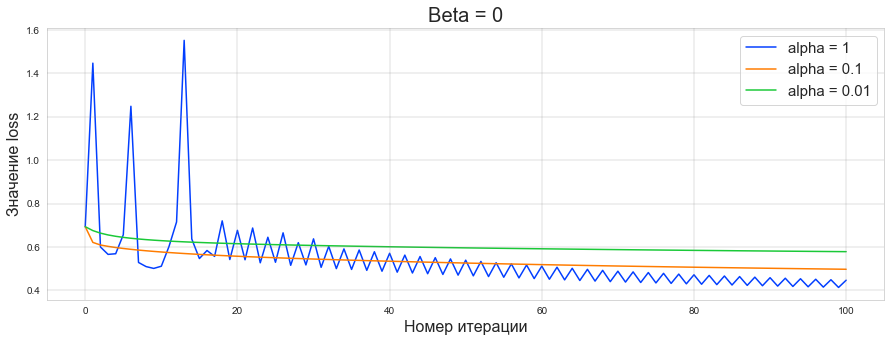

In [181]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=0,
             tolerance=1e-5, max_iter=100, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [352]:
fig.savefig('exersize_3_1.pdf')

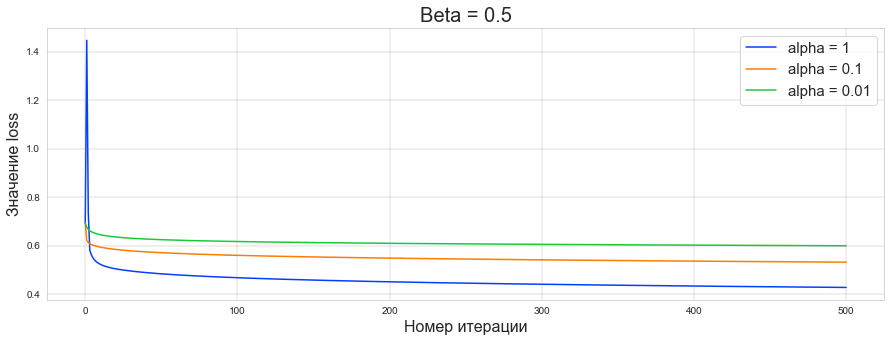

In [169]:
plt.figure(figsize=(15, 5))
plt.title("Beta = 0.5", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=0.5, 
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [170]:
fig.savefig('exersize_3_2.pdf')

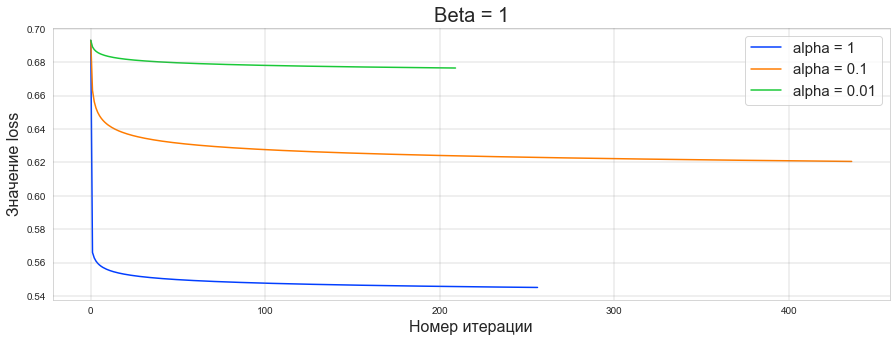

In [355]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=1,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, target, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [356]:
fig.savefig('exersize_3_3.pdf')

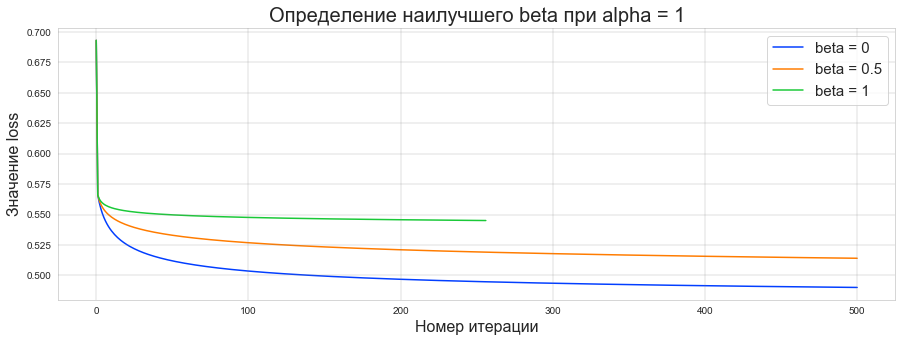

In [357]:
fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего beta при alpha = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for b in beta:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=b,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, target, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='beta = '+str(b))
plt.legend(fontsize = 15)

In [358]:
fig.savefig('exersize_3_4.pdf')

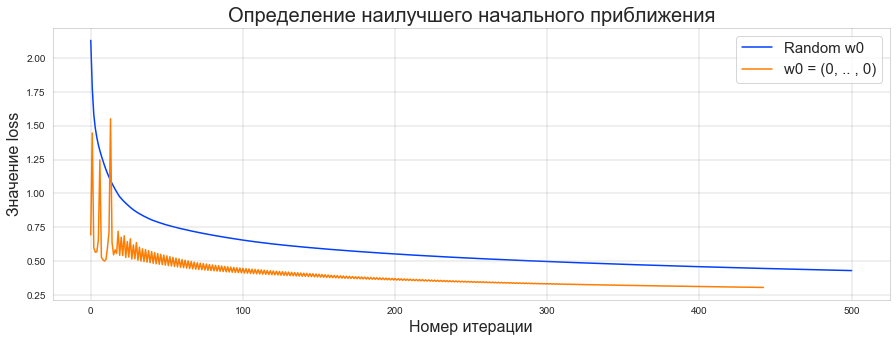

In [86]:
fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего начального приближения", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=0, 
                   tolerance=1e-5, max_iter=500, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=None, trace=True)
plt.plot(np.arange(len(history['func'])), history['func'], label='Random w0')
history = clf.fit(X_train, y_train, w_0=w0, trace=True)
plt.plot(np.arange(len(history['func'])), history['func'], label='w0 = (0, .. , 0)')
plt.legend(fontsize = 15)

In [87]:
fig.savefig('exersize_3_5.pdf')

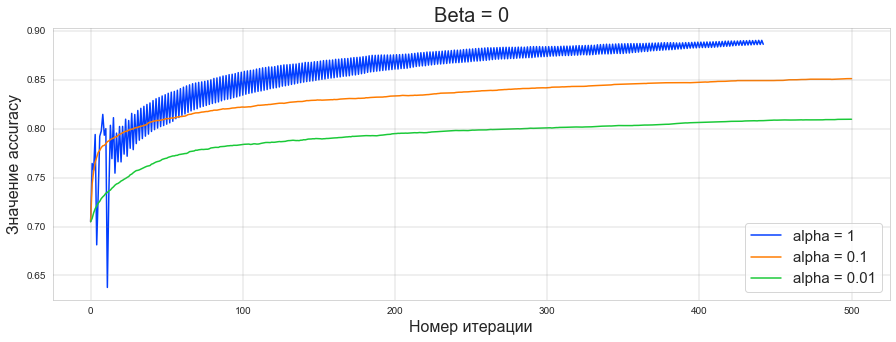

In [78]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=0,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [79]:
fig.savefig('exersize_3_6.pdf')

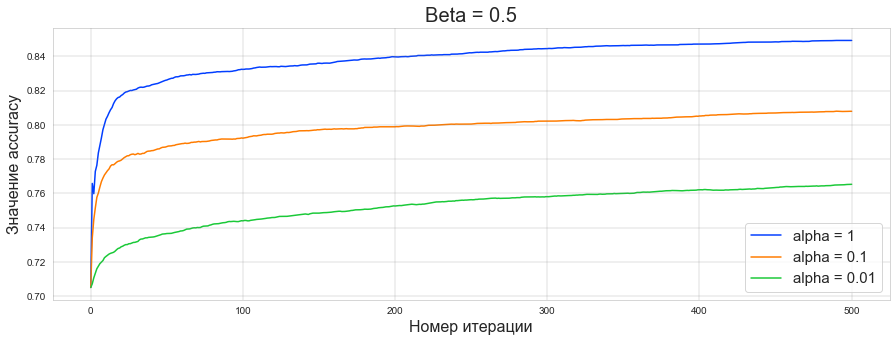

In [165]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0.5", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=0.5,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [166]:
fig.savefig('exersize_3_7.pdf')

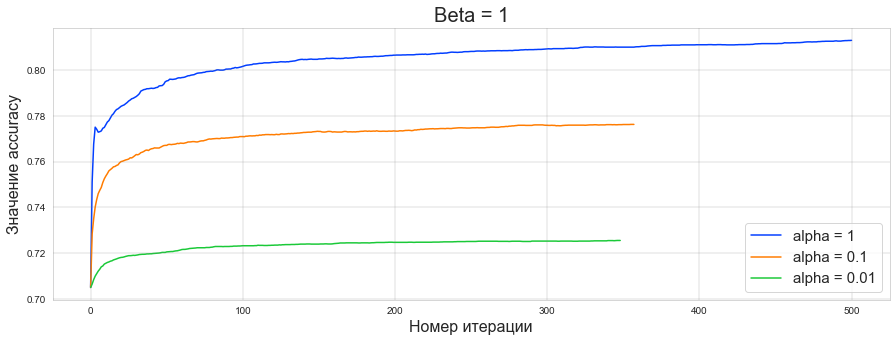

In [167]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=a, step_beta=1,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [168]:
fig.savefig('exersize_3_8.pdf')

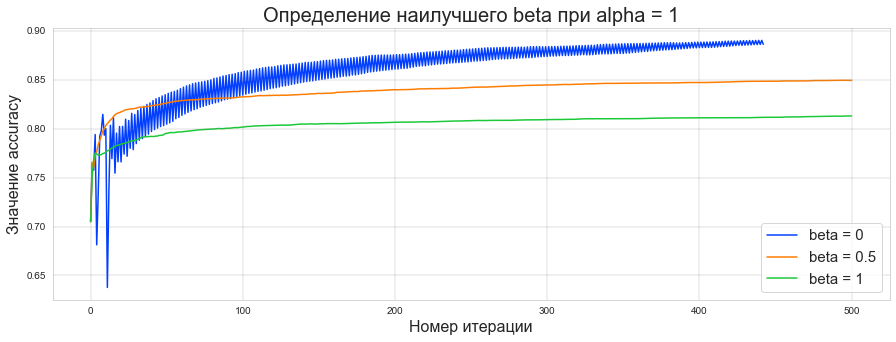

In [88]:
fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего beta при alpha = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for b in beta:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=b,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='beta = '+str(b))
plt.legend(fontsize = 15)

In [89]:
fig.savefig('exersize_3_9.pdf')

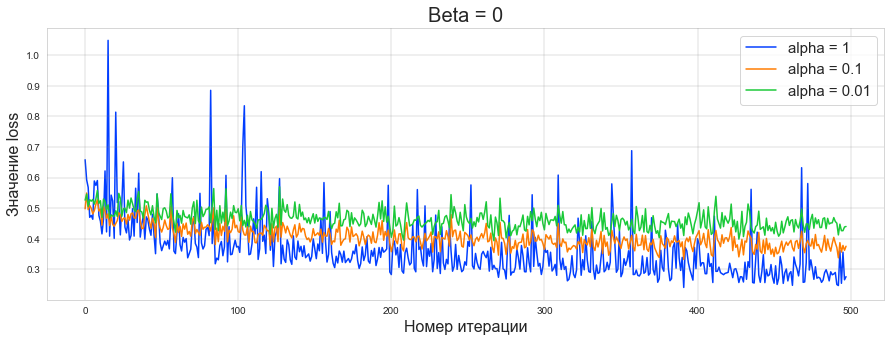

In [134]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=0,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, target, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='alpha = ' + str(a))
plt.legend(fontsize = 15)

In [135]:
fig.savefig('exersize_4_1.pdf')

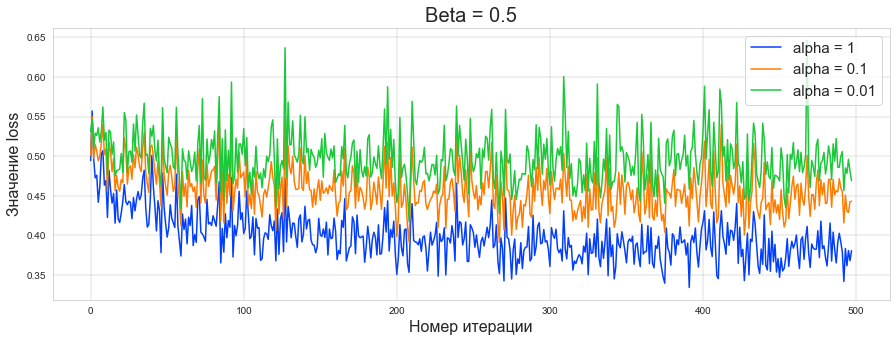

In [136]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0.5", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=0.5,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, target, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='alpha = ' + str(a))
plt.legend(fontsize = 15)

In [137]:
fig.savefig('exersize_4_2.pdf')

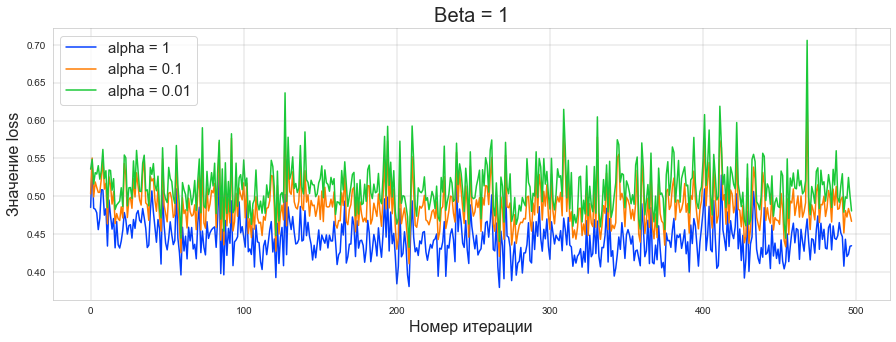

In [138]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=1,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, target, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='alpha = ' + str(a))
plt.legend(fontsize = 15)

In [139]:
fig.savefig('exersize_4_3.pdf')

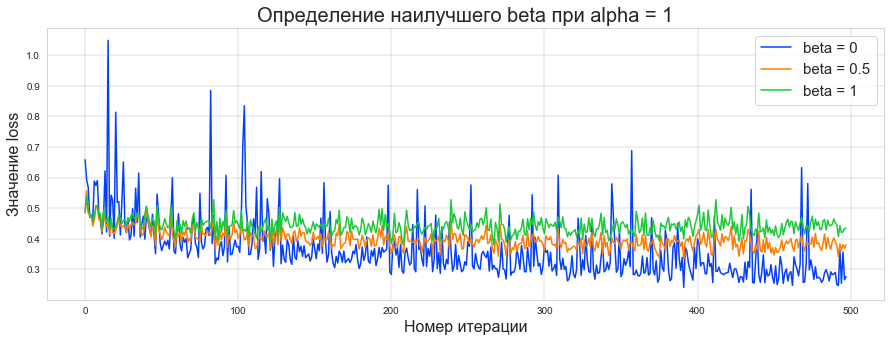

In [143]:
fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего beta при alpha = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for b in beta:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=b,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, target, w_0=w0, trace=True)
    plt.plot(np.arange(len(history['func'])), history['func'], label='beta = ' + str(b))
plt.legend(fontsize = 15)

In [144]:
fig.savefig('exersize_4_4.pdf')

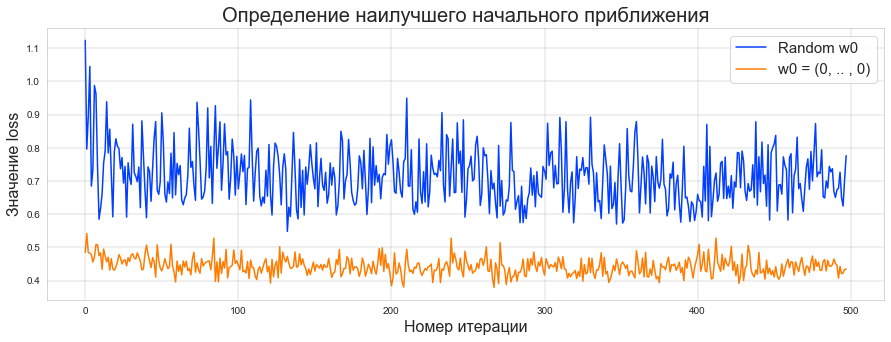

In [148]:
fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего начального приближения", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение loss', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=b,
             tolerance=1e-5, max_iter=500, l2_coef=0)
history = clf.fit(X_train, target, w_0=None, trace=True)
plt.plot(np.arange(len(history['func'])), history['func'], label='Random w0')
history = clf.fit(X_train, target, w_0=w0, trace=True)
plt.plot(np.arange(len(history['func'])), history['func'], label='w0 = (0, .. , 0)')
plt.legend(fontsize = 15)

In [149]:
fig.savefig('exersize_4_5.pdf')

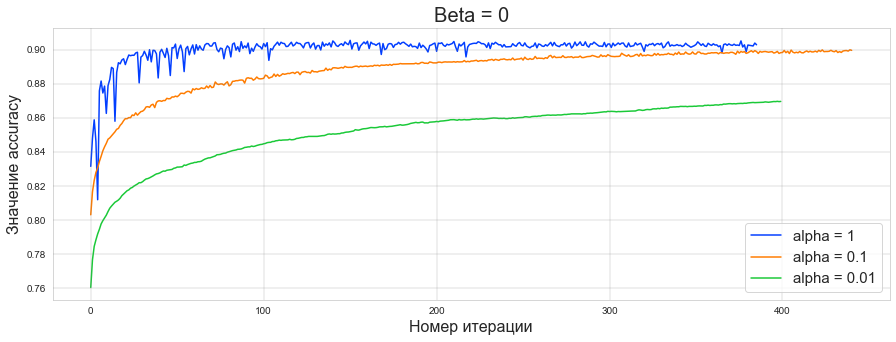

In [150]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=0,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [151]:
fig.savefig('exersize_4_6.pdf')

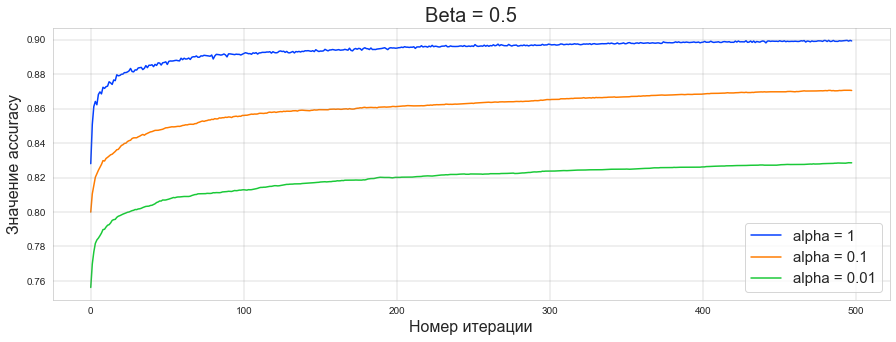

In [152]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 0.5", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=0.5,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [153]:
fig.savefig('exersize_4_7.pdf')

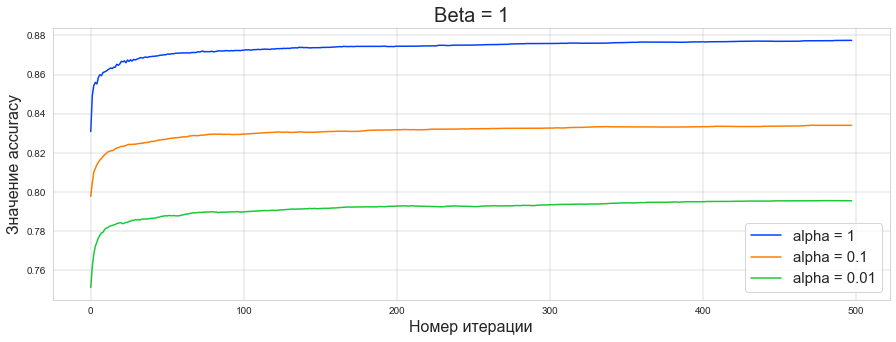

In [154]:
fig = plt.figure(figsize=(15, 5))
plt.title("Beta = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for a in alpha:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=a, step_beta=1,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='alpha = '+str(a))
plt.legend(fontsize = 15)

In [155]:
fig.savefig('exersize_4_8.pdf')

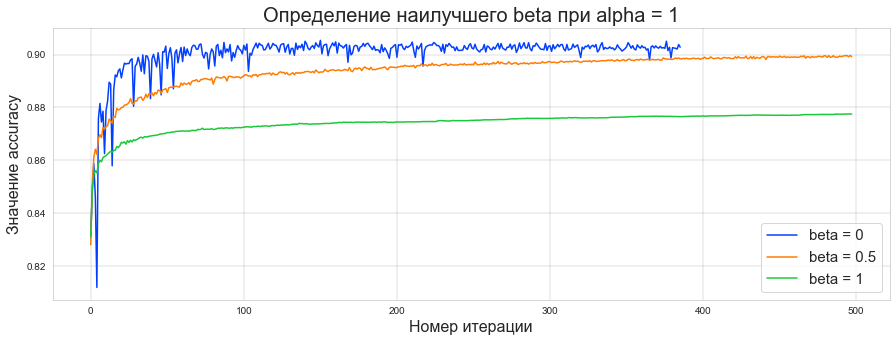

In [156]:
fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего beta при alpha = 1", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for b in beta:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=b,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='beta = '+str(b))
plt.legend(fontsize = 15)

In [157]:
fig.savefig('exersize_4_9.pdf')

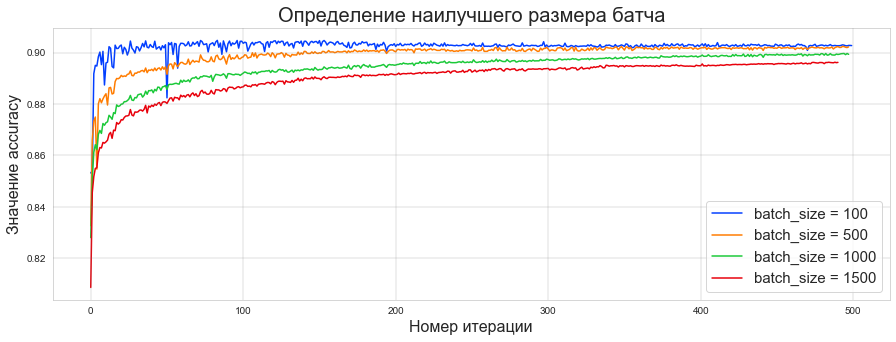

In [160]:
batch = [100, 500, 1000, 1500]

fig = plt.figure(figsize=(15, 5))
plt.title("Определение наилучшего размера батча", fontsize=20)

plt.xlabel('Номер итерации', fontsize=16)
plt.ylabel('Значение accuracy', fontsize=16)
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
for b in batch:
    clf = SGDClassifier(loss_function='binary_logistic', batch_size=b, step_alpha=1, step_beta=0.5,
             tolerance=1e-5, max_iter=500, l2_coef=0)
    history = clf.fit(X_train, y_train, w_0=w0, trace=False, accuracy=True, X_test=X_test, y_test=y_test)
    plt.plot(np.arange(len(history)), history, label='batch_size = '+str(b))
plt.legend(fontsize = 15)

In [161]:
fig.savefig('exersize_4_10.pdf')

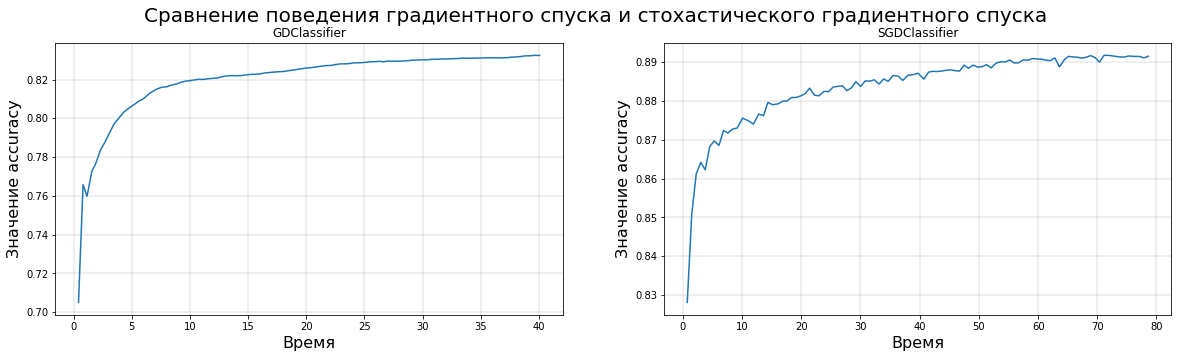

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Сравнение поведения градиентного спуска и стохастического градиентного спуска", fontsize=20)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=0.5,
                   tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=w0, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
ax[0].set_title('GDClassifier')
ax[0].plot(history['time'], history['accuracy'])
ax[0].set_xlabel('Время', fontsize=16)
ax[0].set_ylabel('Значение accuracy', fontsize=16)
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=w0, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
ax[1].plot(history['time'], history['accuracy'])
ax[1].set_title('SGDClassifier')
ax[1].set_xlabel('Время', fontsize=16)
ax[1].set_ylabel('Значение accuracy', fontsize=16)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)

In [27]:
fig.savefig('exersize_5_1.pdf')

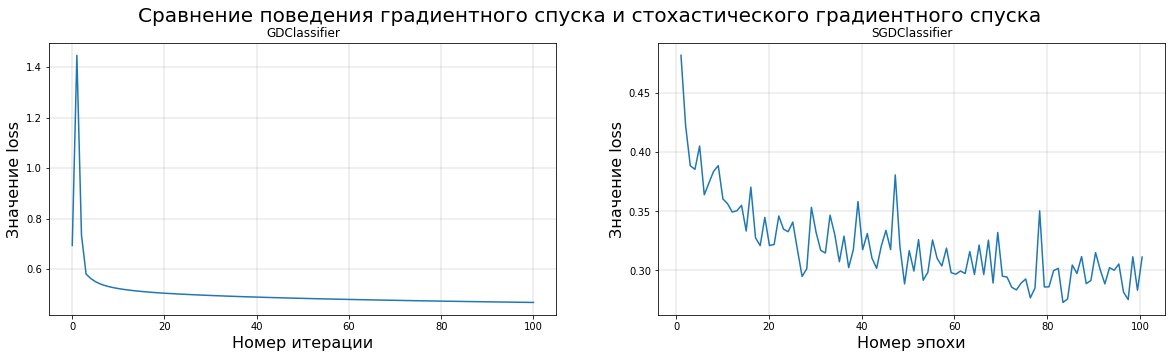

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Сравнение поведения градиентного спуска и стохастического градиентного спуска", fontsize=20)

gd_clf = GDClassifier(loss_function='binary_logistic', step_alpha=1, step_beta=0.5,
                   tolerance=1e-5, max_iter=100, l2_coef=0)
history = gd_clf.fit(X_train, y_train, w_0=w0, trace=True)
ax[0].set_title('GDClassifier')
ax[0].plot(np.arange(len(history['func'])), history['func'])
ax[0].set_xlabel('Номер итерации', fontsize=16)
ax[0].set_ylabel('Значение loss', fontsize=16)
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
sgd_clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = sgd_clf.fit(X_train, y_train, w_0=w0, trace=True)
ax[1].plot(history['epoch_num'], history['func'])
ax[1].set_title('SGDClassifier')
ax[1].set_xlabel('Номер эпохи', fontsize=16)
ax[1].set_ylabel('Значение loss', fontsize=16)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)

In [29]:
fig.savefig('exersize_5_2.pdf')

# Лемматизация

In [65]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [95]:
train_data = pd.read_csv('toxic_train.csv')
test_data = pd.read_csv('toxic_test.csv')

target = train_data.is_toxic.values
target = (-1) ** (target + 1)
train_data = train_data.drop('is_toxic', axis=1)

In [96]:
stop_words = stopwords.words("english")

In [97]:
train_data['comment_text'] = train_data.comment_text.str.lower()
train_data['comment_text'] = train_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                             ' ', x, count=0))

In [98]:
test_data['comment_text'] = test_data.comment_text.str.lower()
test_data['comment_text'] = test_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                           ' ', x, count=0))

In [99]:
lemmatizer = WordNetLemmatizer()
train_data['comment_text'] = [nltk.word_tokenize(token) for token in train_data['comment_text']] 
train_data['comment_text'] = [' '.join([lemmatizer.lemmatize(w) for w in word_list if w not in stop_words]) for word_list in train_data['comment_text']] 

In [100]:
lemmatizer = WordNetLemmatizer()
test_data['comment_text'] = [nltk.word_tokenize(token) for token in test_data['comment_text']] 
test_data['comment_text'] = [' '.join([lemmatizer.lemmatize(w) for w in word_list if w not in stop_words]) for word_list in test_data['comment_text']] 

In [101]:
count_vect = CountVectorizer(min_df=0.0001)
train_data = count_vect.fit_transform(train_data['comment_text'])
test_data = count_vect.transform(test_data['comment_text'])

In [102]:
train_data.shape

(52061, 14305)

In [103]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(train_data, target, train_size=0.65, random_state=241)

In [104]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=w0, trace=True, accuracy=True, X_test=X_test, y_test=y_test)

In [105]:
history['accuracy'][len(history['accuracy']) - 1]

0.891559653166502

In [106]:
history['time'][len(history['time']) - 1]

40.78390550613403

In [190]:
new_w0 = np.zeros(new_X_train.shape[1])

In [110]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(new_X_train, new_y_train, w_0=w0, trace=True, accuracy=True, X_test=new_X_test, y_test=new_y_test)

In [111]:
history['accuracy'][len(history['accuracy']) - 1]

0.8928767423992976

In [112]:
history['time'][len(history['time']) - 1]

30.148884057998657

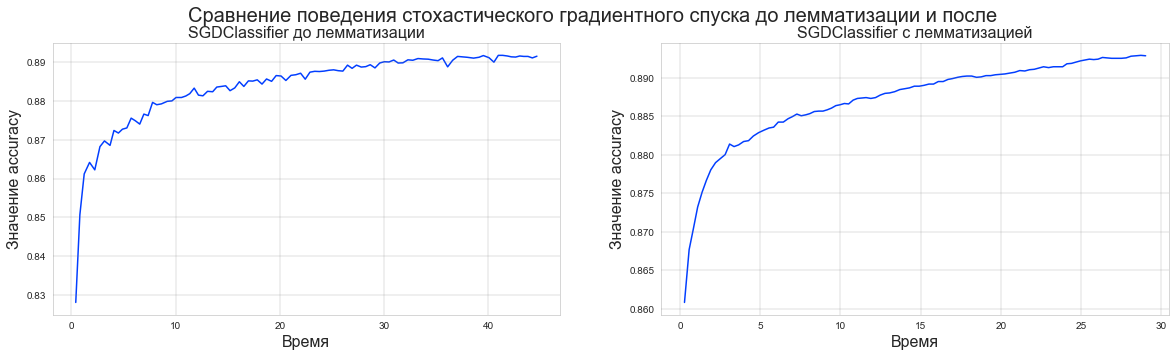

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Сравнение поведения стохастического градиентного спуска до лемматизации и после", fontsize=20)

clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=w0, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
ax[0].set_title('SGDClassifier до лемматизации', fontsize=16)
ax[0].plot(history['time'], history['accuracy'])
ax[0].set_xlabel('Время', fontsize=16)
ax[0].set_ylabel('Значение accuracy', fontsize=16)
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(new_X_train, new_y_train, w_0=new_w0, trace=True, accuracy=True, X_test=new_X_test, y_test=new_y_test)
ax[1].plot(history['time'], history['accuracy'])
ax[1].set_title('SGDClassifier с лемматизацией', fontsize=16)
ax[1].set_xlabel('Время', fontsize=16)
ax[1].set_ylabel('Значение accuracy', fontsize=16)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)

In [207]:
fig.savefig('exersize_6_1.pdf')

# BagOfWords или Tfidf

In [334]:
train_data = pd.read_csv('toxic_train.csv')
test_data = pd.read_csv('toxic_test.csv')

In [335]:
train_data['comment_text'] = train_data.comment_text.str.lower()
train_data['comment_text'] = train_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                             ' ', x, count=0))

test_data['comment_text'] = test_data.comment_text.str.lower()
test_data['comment_text'] = test_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                           ' ', x, count=0))

In [336]:
count_vect = CountVectorizer(min_df=0.0001, max_df=0.1, ngram_range=(1, 3))
train_data = count_vect.fit_transform(train_data['comment_text'])
test_data = count_vect.transform(test_data['comment_text'])

In [337]:
tfidf_transformer = TfidfTransformer(use_idf=True)
train_tfidf = tfidf_transformer.fit_transform(train_data)
test_tfidf = tfidf_transformer.transform(test_data)

In [338]:
train_tfidf.shape

(52061, 105225)

In [339]:
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(train_tfidf, target, 
                                                                            train_size=0.65, random_state=241)

In [340]:
w0 = np.zeros(tfidf_X_train.shape[1])

In [341]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(tfidf_X_train, tfidf_y_train, w_0=w0, trace=True, accuracy=True, X_test=tfidf_X_test, y_test=tfidf_y_test)

In [342]:
history['accuracy'][len(history['accuracy']) - 1]

0.8136867522774668

In [343]:
history['time'][len(history['time']) - 1]

55.650076150894165

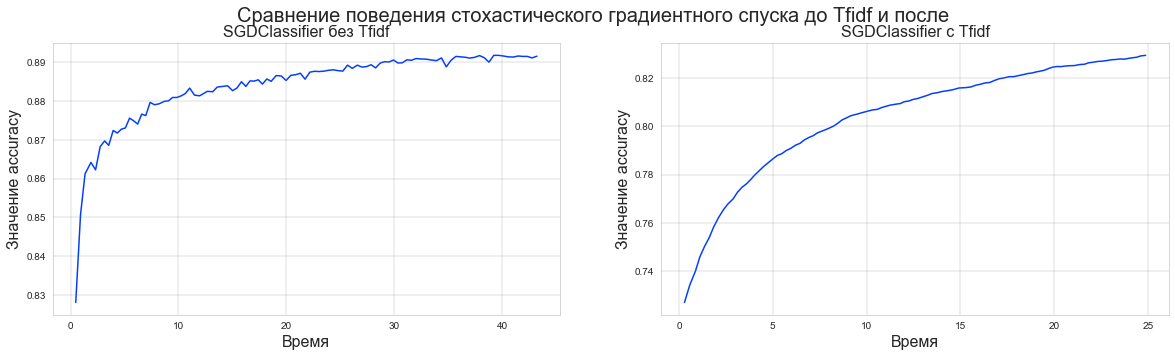

In [208]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Сравнение поведения стохастического градиентного спуска до Tfidf и после", fontsize=20)

clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(X_train, y_train, w_0=w0, trace=True, accuracy=True, X_test=X_test, y_test=y_test)
ax[0].set_title('SGDClassifier без Tfidf', fontsize=16)
ax[0].plot(history['time'], history['accuracy'])
ax[0].set_xlabel('Время', fontsize=16)
ax[0].set_ylabel('Значение accuracy', fontsize=16)
ax[0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=100, l2_coef=0)
history = clf.fit(tfidf_X_train, tfidf_y_train, w_0=w0, trace=True, accuracy=True, X_test=tfidf_X_test, y_test=tfidf_y_test)
ax[1].plot(history['time'], history['accuracy'])
ax[1].set_title('SGDClassifier с Tfidf', fontsize=16)
ax[1].set_xlabel('Время', fontsize=16)
ax[1].set_ylabel('Значение accuracy', fontsize=16)
ax[1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=1)

In [209]:
fig.savefig('exersize_6_2.pdf')

# Итоговое предсказание

In [381]:
train_data = pd.read_csv('toxic_train.csv')
test_data = pd.read_csv('toxic_test.csv')

In [382]:
y_train = train_data.is_toxic.values
y_test = test_data.is_toxic.values
y_train = (-1) ** (y_train + 1)
y_test = (-1) ** (y_test + 1)
train_data = train_data.drop('is_toxic', axis=1)
test_data = test_data.drop('is_toxic', axis=1)

In [359]:
stop_words = stopwords.words("english")

In [384]:
train_data['comment_text'] = train_data.comment_text.str.lower()
train_data['comment_text'] = train_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                             ' ', x, count=0))

In [385]:
test_data['comment_text'] = test_data.comment_text.str.lower()
test_data['comment_text'] = test_data['comment_text'].map(lambda x: re.sub('[^0-9a-zA-Zа-яА-ЯёЁ]', 
                                                                           ' ', x, count=0))

In [362]:
lemmatizer = WordNetLemmatizer()
train_data['comment_text'] = [nltk.word_tokenize(token) for token in train_data['comment_text']] 
train_data['comment_text'] = [' '.join([lemmatizer.lemmatize(w) for w in word_list if w not in stop_words]) for word_list in train_data['comment_text']] 

In [363]:
lemmatizer = WordNetLemmatizer()
test_data['comment_text'] = [nltk.word_tokenize(token) for token in test_data['comment_text']] 
test_data['comment_text'] = [' '.join([lemmatizer.lemmatize(w) for w in word_list if w not in stop_words]) for word_list in test_data['comment_text']] 

In [364]:
count_vect = CountVectorizer(min_df=0.0001, max_df=0.1)
train_data = count_vect.fit_transform(train_data['comment_text'])
test_data = count_vect.transform(test_data['comment_text'])

In [366]:
w0 = np.zeros(train_data.shape[1])

In [367]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=1000, l2_coef=0)
clf.fit(train_data, y_train, w_0=w0, trace=False)
y_pred = clf.predict(test_data)

In [368]:
accuracy_score(y_test, y_pred)

0.8713000580383052

In [369]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=1000, l2_coef=1)
clf.fit(train_data, y_train, w_0=w0, trace=False)
y_pred = clf.predict(test_data)

In [370]:
accuracy_score(y_test, y_pred)

0.818436834977752

In [371]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=1000, l2_coef=0.1)
clf.fit(train_data, y_train, w_0=w0, trace=False)
y_pred = clf.predict(test_data)

In [372]:
accuracy_score(y_test, y_pred)

0.8497775198297544

In [373]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=1000, l2_coef=0.01)
clf.fit(train_data, y_train, w_0=w0, trace=False)
y_pred = clf.predict(test_data)

In [374]:
accuracy_score(y_test, y_pred)

0.867382472431805

In [375]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=1000, l2_coef=0.001)
clf.fit(train_data, y_train, w_0=w0, trace=False)
y_pred = clf.predict(test_data)

In [376]:
accuracy_score(y_test, y_pred)

0.8710098665118978

In [377]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=1000, step_alpha=1, step_beta=0.5,
                    tolerance=1e-5, max_iter=1000, l2_coef=0.0001)
clf.fit(train_data, y_train, w_0=w0, trace=False)
y_pred = clf.predict(test_data)

In [378]:
accuracy_score(y_test, y_pred)

0.8717837105823176

In [397]:
error = test_data[(y_test == -1) & (y_pred == 1)]

In [406]:
error.comment_text

1                          dear god this site is horrible 
12                      jews are not a race because you...
17              balance     this page has one sentence ...
27       i will burn you to hell if you revoke my talk ...
30                                        puwersa ng masa 
                               ...                        
15960     antonius pius was a neat guy who was pretty lazy
15964      your vfd comment      why do you call it ame...
15977                                by collaborating with
15990       n  lnkfjjkghdfjgfjgfjhgiofj iojfoijio ioioh...
15993       you are obviously nuts  just like this mont...
Name: comment_text, Length: 2179, dtype: object

In [407]:
error = test_data[(y_test == 1) & (y_pred == -1)]

In [412]:
error.comment_text

38       how dare you vandalize that page about the hms...
655           utterly utterly tiny insignificant anal r...
743                              and cybersex             
834          thank you  i ve done a bit more reading an...
999        shut up          you re very silly to change...
                               ...                        
20598     another holocaust denier  you might as well b...
20606            your recent bizarre actions       have...
20613    no  she was a promising and well known young m...
20630           please  someone fix this godawful article 
20652            yeah  sure  you say you welcome discus...
Name: comment_text, Length: 472, dtype: object